In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
import json, os, math
from torch.nn import functional as F
from pathlib import Path
import random
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Data Preparation

In [4]:
data_path = Path('Data')
train_path = data_path / 'seg_train'
test_path = data_path/'seg_test'
pred_path = data_path/'seg_pred'

def test_dir(dir):
    if dir.is_dir():
        print(f"{dir} directory exits.")
    else:
        print(f"Did not find {dir} directory, creating one...")

test_dir(train_path)
test_dir(test_path)
test_dir(pred_path)

Data\seg_train directory exits.
Data\seg_test directory exits.
Data\seg_pred directory exits.


In [5]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(data_path)

There are 3 directories and 0 images in 'Data'.
There are 1 directories and 0 images in 'Data\seg_pred'.
There are 0 directories and 7301 images in 'Data\seg_pred\seg_pred'.
There are 1 directories and 0 images in 'Data\seg_test'.
There are 6 directories and 0 images in 'Data\seg_test\seg_test'.
There are 0 directories and 437 images in 'Data\seg_test\seg_test\buildings'.
There are 0 directories and 474 images in 'Data\seg_test\seg_test\forest'.
There are 0 directories and 553 images in 'Data\seg_test\seg_test\glacier'.
There are 0 directories and 525 images in 'Data\seg_test\seg_test\mountain'.
There are 0 directories and 510 images in 'Data\seg_test\seg_test\sea'.
There are 0 directories and 501 images in 'Data\seg_test\seg_test\street'.
There are 1 directories and 0 images in 'Data\seg_train'.
There are 6 directories and 0 images in 'Data\seg_train\seg_train'.
There are 0 directories and 2191 images in 'Data\seg_train\seg_train\buildings'.
There are 0 directories and 2271 images in 

Random image path: Data\seg_train\seg_train\street\10099.jpg
Image class: street
Image height: 150
Image width: 150


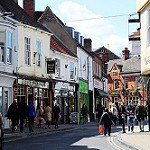

In [8]:
random.seed(24)

train_image_list = list(train_path.glob("*/*/*.jpg"))
random_image = random.choice(train_image_list)

image_class = random_image.parent.stem
img = Image.open(random_image)

print(f"Random image path: {random_image}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

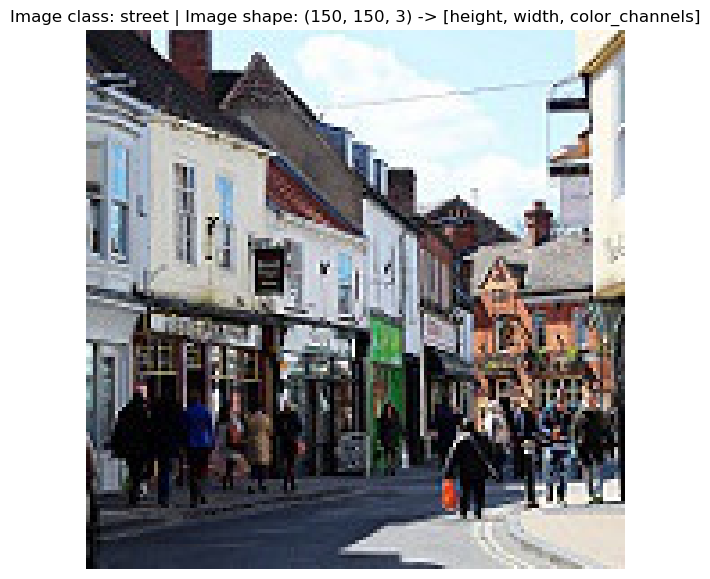

In [9]:
img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [10]:
data_transform = transforms.Compose([
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    # Resize the images to 64x64
    transforms.Resize(size=(128, 128)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.RandomResizedCrop((128, 128), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


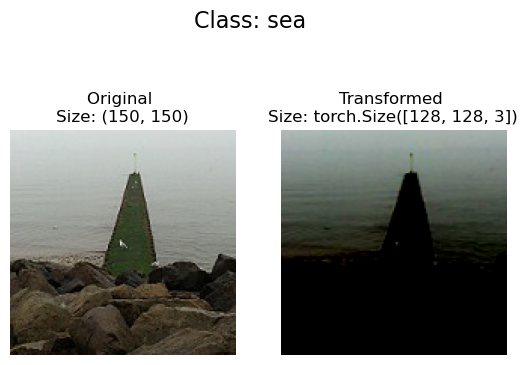

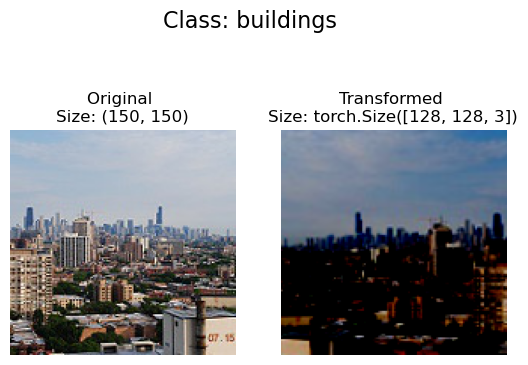

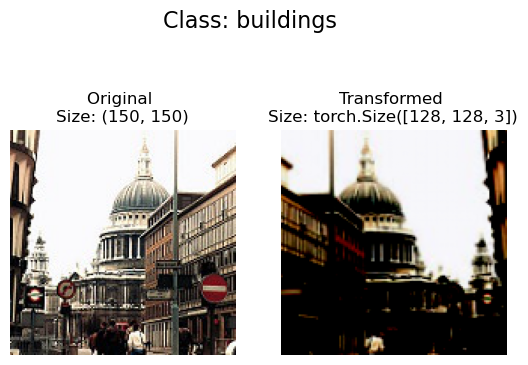

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(train_image_list, 
                        transform=data_transform, 
                        n=3)

In [12]:

train_data = datasets.ImageFolder(root=train_path/'seg_train', # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_path/'seg_test', 
                                 transform=data_transform)

pred_data = datasets.ImageFolder(root = pred_path, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}\nPrediction Data:\n{pred_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 14034
    Root location: Data\seg_train\seg_train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 3000
    Root location: Data\seg_test\seg_test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               Normalize(mean=(0.5, 0

In [13]:
class_names = test_data.classes
class_dict = train_data.class_to_idx
class_dict

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [14]:
img, label = train_data[0][0], train_data[0][1]

print(img.shape)

torch.Size([3, 128, 128])


In [15]:
def plot_image(img): 
    img_permute = img.permute(1,2,0)
    print(f"Original shape: {img.shape} -> [color_channels, height, width]")
    print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

    # Plot the image
    plt.figure(figsize=(10, 7))
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
    # plt.title(class_names[label], fontsize=14)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original shape: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Image permute shape: torch.Size([128, 128, 3]) -> [height, width, color_channels]


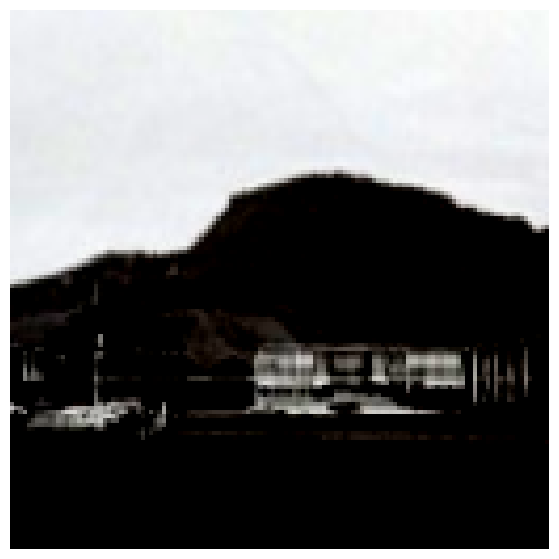

In [16]:
plot_image(img)

In [17]:
train_loader = DataLoader(dataset = train_data, batch_size = 32, num_workers=1, shuffle=True)
test_loader = DataLoader(dataset=  test_data, batch_size= 32, num_workers=1, shuffle=False)
pred_loader = DataLoader(dataset=pred_data, batch_size=32, num_workers=1)

train_loader, test_loader, pred_loader

(<torch.utils.data.dataloader.DataLoader at 0x23a97163d10>,
 <torch.utils.data.dataloader.DataLoader at 0x23a90009ad0>)

In [18]:
img, label = next(iter(train_loader))

print(f"{img.shape} => [batch_size, color_channels, height , width]")
print(label.shape)

torch.Size([32, 3, 128, 128]) => [batch_size, color_channels, height , width]
torch.Size([32])


# Vision Transformer from Scratch

## Code for ViTs

In [167]:
#@title ViT Implementation 🔥
import math


class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415

    Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    """

    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))


class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Calculate the number of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        # Create a learnable [CLS] token
        # Similar to BERT, the [CLS] token is added to the beginning of the input sequence
        # and is used to classify the entire sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        # Create position embeddings for the [CLS] token and the patch embeddings
        # Add 1 to the sequence length for the [CLS] token
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size
        # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        # Create the query, key, and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)


class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a list of attention heads
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Calculate the attention output for each attention head
        attention_outputs = [head(x) for head in self.heads]
        # Concatenate the attention outputs from each attention head
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        # Project the concatenated attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)


class FasterMultiHeadAttention(nn.Module):
    """
    Multi-head attention module with some optimizations.
    All the heads are processed simultaneously with merged query, key, and value projections.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a linear layer to project the query, key, and value
        self.qkv_projection = nn.Linear(self.hidden_size, self.all_head_size * 3, bias=self.qkv_bias)
        self.attn_dropout = nn.Dropout(config["attention_probs_dropout_prob"])
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Project the query, key, and value
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, all_head_size * 3)
        qkv = self.qkv_projection(x)
        # Split the projected query, key, and value into query, key, and value
        # (batch_size, sequence_length, all_head_size * 3) -> (batch_size, sequence_length, all_head_size)
        query, key, value = torch.chunk(qkv, 3, dim=-1)
        # Resize the query, key, and value to (batch_size, num_attention_heads, sequence_length, attention_head_size)
        batch_size, sequence_length, _ = query.size()
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.attn_dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        # Resize the attention output
        # from (batch_size, num_attention_heads, sequence_length, attention_head_size)
        # To (batch_size, sequence_length, all_head_size)
        attention_output = attention_output.transpose(1, 2) \
                                           .contiguous() \
                                           .view(batch_size, sequence_length, self.all_head_size)
        # Project the attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            return (attention_output, attention_probs)


class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.use_faster_attention = config.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # Skip connection
        x = x + attention_output
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)


class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)


class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0, :])
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

## Helper functions


In [165]:

def save_model(model, config, exp_name, models_dir='models'):
    """
    Save the trained model and its configuration to the specified directory.
    
    Args:
    - model: The trained model to be saved.
    - config: Configuration object used to create the model.
    - exp_name: Name of the experiment or model.
    - models_dir: Directory where models will be saved.
    """
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    
    # Remove invalid characters from exp_name
    exp_name = exp_name.replace("*", "_")  # Replace '*' with '_'
    
    model_path = os.path.join(models_dir, f"{exp_name}.pt")
    torch.save({'model_state_dict': model.state_dict(), 'config': config}, model_path)
    print(f"Model saved at: {model_path}")

def load_model(model_class, exp_name, models_dir='models'):
    """
    Load a previously saved model.
    
    Args:
    - model_class: The class of the model to be loaded.
    - exp_name: Name of the experiment or model.
    - models_dir: Directory where models are saved.
    
    Returns:
    - model: The loaded model.
    """
    model_path = os.path.join(models_dir, f"{exp_name}.pt")
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model '{exp_name}' not found in directory '{models_dir}'")
    
    checkpoint = torch.load(model_path)
    config = checkpoint['config']
    
    model = model_class(config)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model loaded from: {model_path}")
    return model

## Training the model

In [169]:
# Define a configuration dictionary
config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.1,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 128,
    "num_classes": 6, # num_classes of Intel Dataset
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}

In [171]:
exp_name = 'vit-10epochs_with_interpolation' #@param {type:"string"}
batch_size = 32 #@param {type: "integer"}
epochs = 10 #@param {type: "integer"}
lr = 1e-2  #@param {type: "number"}
save_model_every = 0 #@param {type: "integer"}

In [310]:
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

        # Save the experiment
        return self.model, train_losses, test_losses, accuracies

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

In [311]:
save_model_every_n_epochs = save_model_every
model = ViTForClassfication(config)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
output, train_losses, test_losses, accuracies = trainer.train(train_loader, test_loader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)

Epoch: 1, Train loss: 1.4578, Test loss: 1.1184, Accuracy: 0.5363
Epoch: 2, Train loss: 1.0523, Test loss: 1.0033, Accuracy: 0.6230
Epoch: 3, Train loss: 0.9472, Test loss: 0.9050, Accuracy: 0.6687
Epoch: 4, Train loss: 0.8678, Test loss: 0.8107, Accuracy: 0.6760
Epoch: 5, Train loss: 0.8042, Test loss: 0.7317, Accuracy: 0.7280
Epoch: 6, Train loss: 0.7558, Test loss: 0.7494, Accuracy: 0.7143
Epoch: 7, Train loss: 0.7032, Test loss: 0.7408, Accuracy: 0.7220
Epoch: 8, Train loss: 0.6863, Test loss: 0.6657, Accuracy: 0.7567
Epoch: 9, Train loss: 0.6630, Test loss: 0.6746, Accuracy: 0.7553
Epoch: 10, Train loss: 0.6408, Test loss: 0.6935, Accuracy: 0.7547


Dataset with Interpolation and normalization: Accuracy 75%, time: 66min

Dataset without Interpolation or normalization: Acuuracy 76%, time: 90min

Observation:
- The time for training of the dataset which was augmented was considerably lower than the one which was not normalized.
- However contrary to the normal assumption, the un augmented dataset was more stable during the training than the normalized dataset.


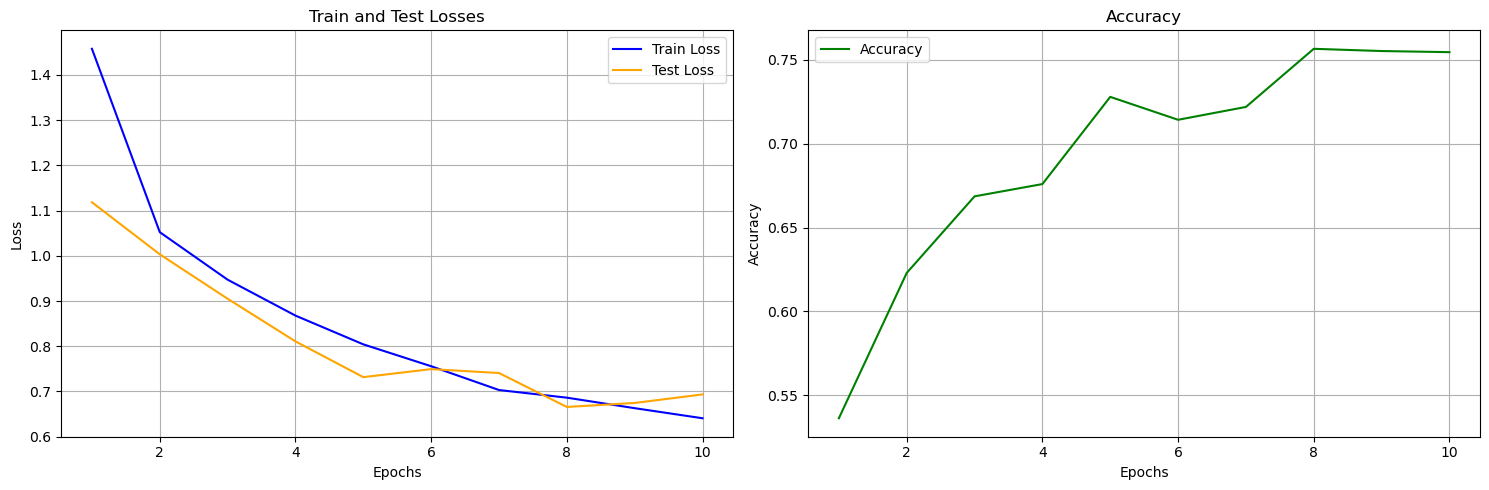

In [318]:

epochs = range(1, len(train_losses) + 1)  # Assuming train_losses, test_losses, and accuracies have the same length

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plotting train and test losses
axs[0].plot(epochs, train_losses, label='Train Loss', color='blue')
axs[0].plot(epochs, test_losses, label='Test Loss', color='orange')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Train and Test Losses')
axs[0].legend()
axs[0].grid(True)

# Plotting accuracies
axs[1].plot(epochs, accuracies, label='Accuracy', color='green')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()
axs[1].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show plots
plt.show()


In [ ]:
save_model(output, config, exp_name)

In [ ]:
loaded_model = load_model(ViTForClassfication, exp_name)

In [314]:
tuple(class_names)

('buildings', 'forest', 'glacier', 'mountain', 'sea', 'street')

## Predictions

In [173]:
@torch.no_grad()
def predict_image_class(image, model, classes=('buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'), device="cuda"):
    """
    Predict the class of the input image using the provided Vision Transformer model.

    Args:
    - image: Input image tensor of size [3, 128, 128].
    - model: Vision Transformer model.
    - classes: List of class names.
    - device: Device to run inference on.

    Returns:
    - predicted_class: Predicted class label.
    """
    model.eval()
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    model = model.to(device)  # Move model to device
    logits, _ = model(image)
    predicted_class = torch.argmax(logits, dim=1).item()
    return classes[predicted_class]

In [ ]:


# Example usage:
# Assuming `image` is your input image tensor of size [3, 128, 128] and `model` is your Vision Transformer model
# Make sure your model is already initialized and loaded with weights
predicted_class = predict_image_class(pred_data[1][0], loaded_model)
print("Predicted class:", predicted_class)
plot_image(pred_data[1][0])


# Pytoch Inbuilt Vit_b_16

In [20]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary



In [21]:
# Get a set of pretrained model weights
weights = torchvision.models.ViT_B_16_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

ViT_B_16_Weights.IMAGENET1K_V1

In [79]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [80]:
train_data = datasets.ImageFolder(root=train_path/'seg_train', # target folder of images
                                  transform=auto_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_path/'seg_test', 
                                 transform=auto_transforms)


In [81]:
train_loader = DataLoader(dataset = train_data, batch_size = 32, num_workers=1, shuffle=True)
test_loader = DataLoader(dataset=  test_data, batch_size= 32, num_workers=1, shuffle=False)

train_loader, test_loader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x23ad834c390>,
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

In [82]:
model = torchvision.models.vit_b_16(weights=weights).to(device)

In [85]:
summary(model=model,
        input_size = (32,3,224,224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings =['var_names']
        )

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]         [32, 1000]                768                       False
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]         [32, 768, 14, 14]         (590,592)                 False
├─Encoder (encoder)                                          [32, 197, 768]            [32, 197, 768]            151,296                   False
│    └─Dropout (dropout)                                     [32, 197, 768]            [32, 197, 768]            --                        --
│    └─Sequential (layers)                                   [32, 197, 768]            [32, 197, 768]            --                        False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]            [32, 197, 768]            (7,087,872)     

In [84]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

In [114]:
model.heads[-1] = nn.Linear(in_features=model.heads[-1].in_features, out_features=len(class_names), bias=True).to(device)


In [116]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 6]              8,454                Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [117]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [124]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return model, results

In [125]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output, results = train(model=model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1429 | train_acc: 0.9493 | test_loss: 0.1874 | test_acc: 0.9295
Epoch: 2 | train_loss: 0.1362 | train_acc: 0.9505 | test_loss: 0.1914 | test_acc: 0.9306
Epoch: 3 | train_loss: 0.1322 | train_acc: 0.9516 | test_loss: 0.1887 | test_acc: 0.9300
Epoch: 4 | train_loss: 0.1303 | train_acc: 0.9525 | test_loss: 0.1832 | test_acc: 0.9316
Epoch: 5 | train_loss: 0.1242 | train_acc: 0.9552 | test_loss: 0.1791 | test_acc: 0.9333
Epoch: 6 | train_loss: 0.1214 | train_acc: 0.9558 | test_loss: 0.1808 | test_acc: 0.9326
Epoch: 7 | train_loss: 0.1182 | train_acc: 0.9562 | test_loss: 0.1877 | test_acc: 0.9310
Epoch: 8 | train_loss: 0.1153 | train_acc: 0.9566 | test_loss: 0.1828 | test_acc: 0.9320
Epoch: 9 | train_loss: 0.1142 | train_acc: 0.9567 | test_loss: 0.1838 | test_acc: 0.9350
Epoch: 10 | train_loss: 0.1107 | train_acc: 0.9600 | test_loss: 0.1804 | test_acc: 0.9359


In [126]:
results

{'train_loss': [0.14293778752208028,
  0.13623295244941136,
  0.13216210754295485,
  0.13034064352834823,
  0.12416113090992041,
  0.12135792584932814,
  0.11822100379133008,
  0.11527752914680231,
  0.11418886301012239,
  0.11069025154647699],
 'train_acc': [0.9493324474816502,
  0.9505188559858263,
  0.9516103518096685,
  0.952480384712731,
  0.9552249430523918,
  0.9557944191343963,
  0.9561661604657049,
  0.9566486332574032,
  0.9566644520374589,
  0.95999430523918],
 'test_loss': [0.18739095454579813,
  0.19140345120227875,
  0.1886755641416072,
  0.18318580962442596,
  0.17906706856484425,
  0.18083993741682672,
  0.1877234670757118,
  0.18284860661283056,
  0.18376207389983973,
  0.18039865526457396],
 'test_acc': [0.9295212765957447,
  0.9306294326241136,
  0.9299645390070922,
  0.9316267730496455,
  0.9332890070921986,
  0.9326241134751774,
  0.9309618794326242,
  0.9319592198581561,
  0.9349512411347518,
  0.9359485815602837]}

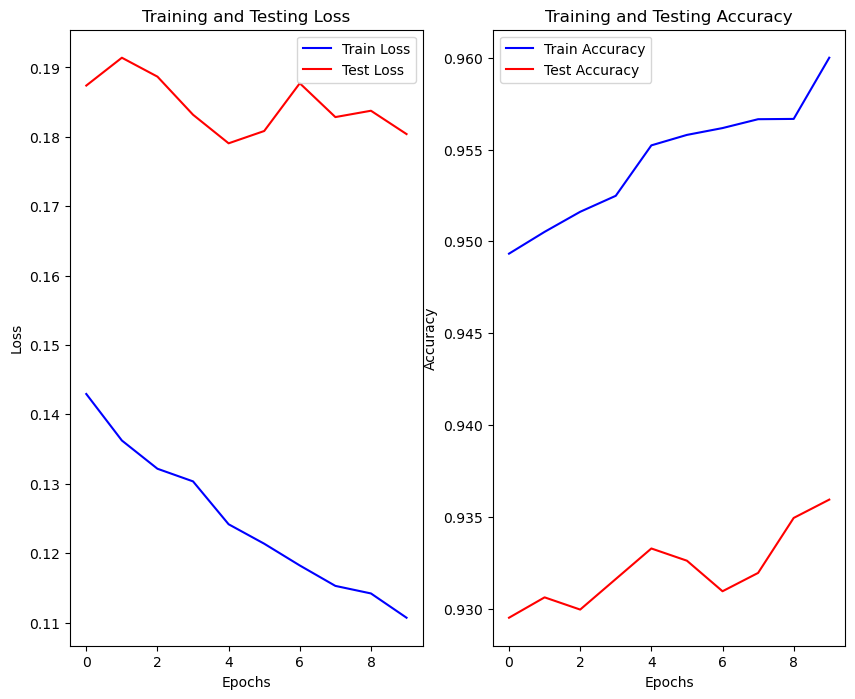

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))

# Plot training and testing loss
axs[0].plot(results['train_loss'], label='Train Loss', color='blue')
axs[0].plot(results['test_loss'], label='Test Loss', color='red')
axs[0].set_title('Training and Testing Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and testing accuracy
axs[1].plot(results['train_acc'], label='Train Accuracy', color='blue')
axs[1].plot(results['test_acc'], label='Test Accuracy', color='red')
axs[1].set_title('Training and Testing Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

In [128]:
save_dir = 'models'
save_path = os.path.join(save_dir, "fine_tuned_vit_b_16_on_intel_image_dataset.pt")
torch.save(model.state_dict(), save_path)

print(f"Model saved at: {save_path}")

Model saved at: models\fine_tuned_vit_b_16_on_intel_image_dataset.pth


In [133]:
pred_data = datasets.ImageFolder(root=pred_path, 
                                 transform=auto_transforms)
pred_loader = DataLoader(dataset=  pred_data, batch_size= 32, num_workers=1, shuffle=False)

In [152]:
images = next(iter(pred_loader))
imputs = images[0].to(device)

In [177]:
@torch.no_grad()
def predict_image(image, model, classes=('buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'), device="cuda"):
    """
    Predict the class of the input image using the provided Vision Transformer model.

    Args:
    - image: Input image tensor of size [3, 128, 128].
    - model: Vision Transformer model.
    - classes: List of class names.
    - device: Device to run inference on.

    Returns:
    - predicted_class: Predicted class label.
    """
    model.eval()
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    model = model.to(device)  # Move model to device
    logits = model(image)
    predicted_class = torch.argmax(logits, dim=1).item()
    return classes[predicted_class]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted class: mountain


Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


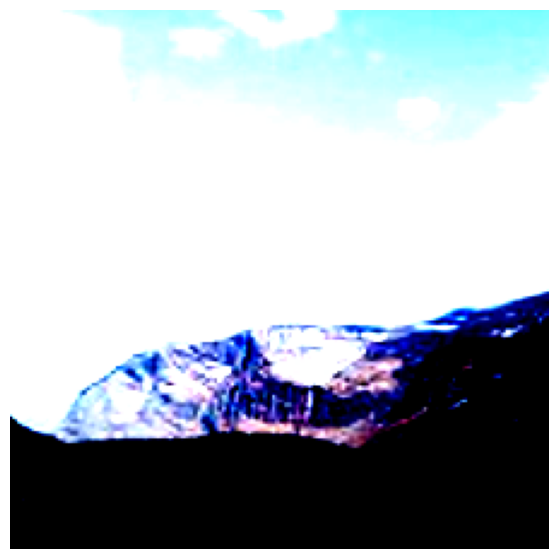

In [181]:
predicted_class = predict_image(pred_data[1][0], output)
print("Predicted class:", predicted_class)
print('\n')
plot_image(pred_data[1][0])